<a href="https://colab.research.google.com/github/Dminor7/ml-praticals-ldrp/blob/master/Consumer_Propensity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Initialize Notebook


Mounting Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Cloning Git Repository to Drive


In [4]:
!git clone https://github.com/Dminor7/ml-praticals-ldrp.git

Cloning into 'ml-praticals-ldrp'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 57 (delta 20), reused 32 (delta 5), pack-reused 0
Unpacking objects: 100% (57/57), done.


Changing Directory

In [76]:
#!ls
%cd /content/ml-praticals-ldrp

/content/ml-praticals-ldrp


# GA Examples


In [77]:
from e_commerce.bigquery import BigQuery
from e_commerce.frame import profiler

What is the total number of transactions generated per device browser in July 2017?

In [81]:
query1 = BigQuery("./service-account.json").get_data("""
     SELECT device.browser, 
    COUNT(totals.transactions) AS cnt_transactions, 
    --sessions with browser
    COUNT(*) AS cnt_all_rows, 
    COUNT(totals.transactions) / COUNT(*) AS sess_conversion_rate,
    sum(totals.totalTransactionRevenue) AS sum_revenue, 
    Sum(totals.transactions) AS  sum_transactions,
    sum(totals.totalTransactionRevenue) / Sum(totals.transactions) AS revenue_per_transaction
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_201707*` 
 GROUP BY device.browser
 ORDER BY sum_transactions DESC   
""")
query1.head()

,browser,cnt_transactions,cnt_all_rows,sess_conversion_rate,sum_revenue,sum_transactions,revenue_per_transaction
0,Chrome,944,49968,0.018892,1.542729e+11,984.0,1.567814e+08
1,Safari,65,13563,0.004792,2.649010e+09,65.0,4.075400e+07
2,Firefox,12,2770,0.004332,5.579800e+08,12.0,4.649833e+07
3,Internet Explorer,7,1527,0.004584,3.034800e+09,7.0,4.335429e+08
4,Edge,2,994,0.002012,9.066000e+07,2.0,4.533000e+07


What is the bounce rate by traffic source?

In [82]:
query2 = BigQuery("./service-account.json").get_data("""
    SELECT trafficSource.source, 
    COUNT(visitId) AS total_visits,
    COUNT(totals.bounces) AS bounce_visits,
    100 * COUNT(totals.bounces) / COUNT(visitId) AS bounce_rate
FROM `bigquery-public-data.google_analytics_sample.ga_sessions_201707*`
GROUP BY trafficSource.source
ORDER BY total_visits DESC   
""")
query2.head()

,source,total_visits,bounce_visits,bounce_rate
0,google,38400,19798,51.557292
1,(direct),19891,8606,43.265799
2,youtube.com,6351,4238,66.729649
3,analytics.google.com,1972,1064,53.955375
4,Partners,1788,936,52.348993


What is the average number of pageviews for users in different continents who made a purchase in July 2017?

In [83]:
query3 = BigQuery("./service-account.json").get_data("""
    SELECT 
    geoNetwork.continent AS Continent,
    COUNT(fullVisitorId) AS total_visitors, 
    COUNT(DISTINCT fullVisitorId) AS unique_visitors, 
    SUM(totals.transactions) AS sum_transactions,
    SUM(totals.totalTransactionRevenue) AS sum_revenue,
    AVG(totals.pageviews) as avg_pageviews -- in sessions where purchase was made

    FROM `bigquery-public-data.google_analytics_sample.ga_sessions_201707*`
    WHERE totals.transactions > 0  
    GROUP BY  Continent
""")
query3.head()

,Continent,total_visitors,unique_visitors,sum_transactions,sum_revenue,avg_pageviews
0,Americas,1011,947,1052,155737020000,25.964392
1,Asia,8,8,8,331780000,27.375000
2,Europe,9,9,9,1342370000,22.111111
3,Africa,2,1,2,3314400000,21.500000
4,(not set),1,1,1,14290000,12.000000


What is the sequence of pages viewed?

In [84]:

query4 = BigQuery("./service-account.json").get_data("""
    SELECT
    fullVisitorId,
    visitId,
    visitNumber,
    hits.hitNumber AS hitNumber,
    hits.page.pagePath AS pagePath
    FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
    UNNEST(hits) as hits
    WHERE _TABLE_SUFFIX BETWEEN '20170701' AND '20170731'
    AND hits.type="PAGE"
    ORDER BY fullVisitorId,visitId,visitNumber,hitNumber
""")
query4.head()

,fullVisitorId,visitId,visitNumber,hitNumber,pagePath
0,0000062267706107999,1499645960,1,1,/home
1,0000085059828173212,1500505105,1,1,/asearch.html
2,0000436683523507380,1500504900,1,1,/home
3,0000436683523507380,1500504900,1,2,/google+redesign/electronics/power/clip+compac...
4,0000436683523507380,1500989127,2,1,/home


In [85]:
# hitNumber has the order within the session
# find a sample customer with more than 1 visit
query4.groupby('fullVisitorId')['visitNumber'].count() 

fullVisitorId
0000062267706107999     1
0000085059828173212     1
0000436683523507380    10
0000450371054833295     1
0000572434142265465     3
                       ..
9998955356642683968    10
9999379202747789695     1
9999430912254902219    24
9999594748540438502     1
9999944980984230465     1
Name: visitNumber, Length: 58569, dtype: int64

In [86]:
query4[query4['fullVisitorId'] == '0000436683523507380']

,fullVisitorId,visitId,visitNumber,hitNumber,pagePath
2,0000436683523507380,1500504900,1,1,/home
3,0000436683523507380,1500504900,1,2,/google+redesign/electronics/power/clip+compac...
4,0000436683523507380,1500989127,2,1,/home
5,0000436683523507380,1500989127,2,2,/google+redesign/bags/backpacks/waterproof+bac...
6,0000436683523507380,1500989127,2,3,/home
7,0000436683523507380,1500989127,2,4,/home
8,0000436683523507380,1500989127,2,5,/google+redesign/electronics
9,0000436683523507380,1500989127,2,6,/google+redesign/office/notebooks+journals/goo...
10,0000436683523507380,1500989127,2,7,/google+redesign/electronics
11,0000436683523507380,1500989127,2,8,/google+redesign/electronics/electronics+acces...


In [89]:
#query4.groupby(['fullVisitorId', 'visitId']).agg({'hitNumber': list, 'pagePath': list})

# Top 10 landing pages from sessions - homepage 50% of time
query4.groupby(['fullVisitorId', 'visitId']).head(1)['pagePath'].value_counts(normalize=True).head(10)

/home                                                                 0.491129
/google+redesign/shop+by+brand/youtube                                0.240836
/google+redesign/apparel/mens/mens+t+shirts                           0.041246
/signin.html                                                          0.020574
/google+redesign/apparel                                              0.012972
/google+redesign/bags                                                 0.012763
/basket.html                                                          0.010908
/google+redesign/shop+by+brand/waze+baby+on+board+window+decal.axd    0.009931
/google+redesign/drinkware                                            0.009150
/google+redesign/accessories/stickers/home                            0.008341
Name: pagePath, dtype: float64

In [73]:
#!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

# Data Gathering & Summarizing

Importing Libraries

In [6]:
import os
import random 
import pandas as pd 
import numpy as np 
from scipy.stats import kurtosis, skew
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.offline as plty
from plotly import tools
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot, plot 
import plotly.graph_objs as go

Reading Datafile (handling columns with JSON values)

In [7]:
import zipfile
# to convert json in df
import json 
# to normalize the json file
from pandas.io.json import json_normalize 
# Columns that have json format
columns = ['device', 'geoNetwork', 'totals', 'trafficSource'] 
dir_path = '/content/ml-praticals-ldrp/'
# p is a fractional number to skiprows and read just a random sample of the our dataset. 
p = 0.07 # *** In this case we will use 70% of data set *** #
#Code to transform the json format columns in table
def json_read(df):
    #joining the [ path + df received]
    data_frame = dir_path + df 
    #Importing the dataset
    zf = zipfile.ZipFile(data_frame +".zip") 
    
    df = pd.read_csv(zf.open(df), 
                     converters={column: json.loads for column in columns}, # loading the json columns properly
                     dtype={'fullVisitorId': 'str'}, # transforming this column to string
                     skiprows=lambda i: i>0 and random.random() > p)# Number of rows that will be imported randomly
    
    for column in columns: #loop to finally transform the columns in data frame
        #It will normalize and set the json to a table
        column_as_df = json_normalize(df[column]) 
        # here will be set the name using the category and subcategory of json columns
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns] 
        # after extracting the values, let drop the original columns
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
        
    # Printing the shape of dataframes that was imported  
    print(f"Loaded {os.path.basename(data_frame)}. Shape: {df.shape}")
    return df 


In [56]:
%%time 
# %%time is used to calculate the timing of code chunk execution #
#df_train = ga_df
df_train = json_read("train_v2.csv")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead



Loaded train_v2.csv. Shape: (119819, 59)
CPU times: user 2min 43s, sys: 6.33 s, total: 2min 49s
Wall time: 2min 52s


In [9]:
df_train.head()

,channelGrouping,customDimensions,date,fullVisitorId,hits,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.hits,totals.pageviews,totals.timeOnSite,totals.newVisits,totals.sessionQualityDim,totals.transactions,totals.transactionRevenue,totals.totalTransactionRevenue,totals.bounces,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adContent
0,Organic Search,"[{'index': '4', 'value': 'APAC'}]",20171016,6338477365942527347,"[{'hitNumber': '1', 'time': '0', 'hour': '11',...",Not Socially Engaged,1508177911,1,1508177911,UC Browser,not available in demo dataset,not available in demo dataset,Android,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,mobile,Asia,Southern Asia,India,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset,1,2,2,73,1,1,NaN,NaN,NaN,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,"[{'index': '4', 'value': 'APAC'}]",20171016,0875141984250977091,"[{'hitNumber': '1', 'time': '0', 'hour': '23',...",Not Socially Engaged,1508223135,1,1508223135,Chrome,not available in demo dataset,not available in demo dataset,Linux,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Asia,Eastern Asia,Taiwan,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,nthu.edu.tw,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,2,2,31,1,1,NaN,NaN,NaN,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Organic Search,"[{'index': '4', 'value': 'North America'}]",20171016,3784396588165854095,"[{'hitNumber': '1', 'time': '0', 'hour': '18',...",Not Socially Engaged,1508203074,1,1508203074,Chrome,not available in demo dataset,not available in demo dataset,Android,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,mobile,Americas,Northern America,Canada,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,start.ca,not available in demo dataset,not available in demo dataset,not 

Data Profiling

In [ ]:
profiler(df_train)

Summarize dataset:   0%|          | 0/67 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Traditional Approach to Summarize data

In [57]:
def describe_data(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values
    
    return summary

In [ ]:
describe_data(df_train)

Dataset Shape: (119907, 59)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value
0,channelGrouping,object,0,8,Referral,Organic Search,Organic Search
1,customDimensions,object,0,6,"[{'index': '4', 'value': 'EMEA'}]","[{'index': '4', 'value': 'North America'}]",[]
2,date,int64,0,638,20171016,20171016,20171016
3,fullVisitorId,object,0,114874,8349655975937271469,7058083259448191057,9630953897602496525
4,hits,object,0,111230,"[{'hitNumber': '1', 'time': '0', 'hour': '4', ...","[{'hitNumber': '1', 'time': '0', 'hour': '10',...","[{'hitNumber': '1', 'time': '0', 'hour': '19',..."
5,socialEngagementType,object,0,1,Not Socially Engaged,Not Socially Engaged,Not Socially Engaged
6,visitId,int64,0,119608,1508152478,1508174145,1508206555
7,visitNumber,int64,0,217,1,1,2
8,visitStartTime,int64,0,119616,1508152478,1508174145,1508206555
9,device.browser,object,0,41,Chrome,Chrome,Chrome


# Date Cleaning and Transformation

Analyzing Columns with Null values

In [58]:
def Null_Count(df):
    df_null = df.isnull().sum().sort_values(ascending = False).rename('Null').reset_index()

    null_count = df_null['Null']
    null_percent = (null_count * 100) / (df.shape[0])

    df_null = pd.concat([df_null['index'],null_count,null_percent], axis=1, keys=['Column','Null_Count','Null_Percent'])

    return df_null[df_null['Null_Count'] != 0]


Null_Count(df_train)

,Column,Null_Count,Null_Percent
0,totals.transactionRevenue,118552,98.942572
1,totals.totalTransactionRevenue,118552,98.942572
2,totals.transactions,118549,98.940068
3,trafficSource.adContent,115280,96.211786
4,trafficSource.adwordsClickInfo.isVideoAd,114475,95.539939
5,trafficSource.adwordsClickInfo.adNetworkType,114475,95.539939
6,trafficSource.adwordsClickInfo.slot,114475,95.539939
7,trafficSource.adwordsClickInfo.page,114475,95.539939
8,trafficSource.adwordsClickInfo.gclId,114464,95.530759
9,trafficSource.isTrueDirect,82410,68.778741


Function to handle missing values

In [59]:
def fill_na(df):   
    df['totals.pageviews'].fillna(1, inplace=True)
    df['totals.newVisits'].fillna(0, inplace=True)
    df['totals.bounces'].fillna(0, inplace=True) 
    df['totals.hits'].fillna(0, inplace=True) 
    df["totals.transactionRevenue"].fillna(0.0, inplace=True)
    
    # Changing datatypes from object to desired ones
    df['totals.pageviews'] = df['totals.pageviews'].astype(int)
    df['totals.newVisits'] = df['totals.newVisits'].astype(int)
    df['totals.bounces'] = df['totals.bounces'].astype(int)
    df['totals.hits'] = df['totals.hits'].astype(int)
    df["totals.transactionRevenue"] = df["totals.transactionRevenue"].astype(float)

    df[df['geoNetwork.city'] == "(not set)"]['geoNetwork.city'] = np.nan
    df['geoNetwork.city'].fillna("NaN", inplace=True)

    return df

df_train = fill_na(df_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Processing Date/Time

In [60]:
from datetime import datetime

# This function is to extract date features
def date_process(df):
    df["date"] = pd.to_datetime(df["date"], format="%Y%m%d") # seting the column as pandas datetime
    df["weekday"] = df['date'].dt.weekday #extracting week day
    df["day"] = df['date'].dt.day # extracting day
    df["month"] = df['date'].dt.month # extracting day
    df["year"] = df['date'].dt.year # extracting day
    df['visitHour'] = (df['visitStartTime'].apply(lambda x: str(datetime.fromtimestamp(x).hour))).astype(int)
    
    return df

df_train = date_process(df_train)

Removing Constant Columns

In [61]:
constant_columns = [col for col in df_train.columns if df_train[col].nunique() == 1]
print(f'Columns : {constant_columns}, \n Num of Columns : {len(constant_columns)}')

df_train.drop(constant_columns, axis=1, inplace=True)

Columns : ['socialEngagementType', 'device.browserVersion', 'device.browserSize', 'device.operatingSystemVersion', 'device.mobileDeviceBranding', 'device.mobileDeviceModel', 'device.mobileInputSelector', 'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName', 'device.flashVersion', 'device.language', 'device.screenColors', 'device.screenResolution', 'geoNetwork.cityId', 'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.networkLocation', 'totals.visits', 'trafficSource.adwordsClickInfo.criteriaParameters', 'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.isTrueDirect'], 
 Num of Columns : 21


Droping Null Columns

In [62]:
Null_Count(df_train)

,Column,Null_Count,Null_Percent
0,totals.totalTransactionRevenue,118552,98.942572
1,totals.transactions,118549,98.940068
2,trafficSource.adContent,115280,96.211786
3,trafficSource.adwordsClickInfo.page,114475,95.539939
4,trafficSource.adwordsClickInfo.adNetworkType,114475,95.539939
5,trafficSource.adwordsClickInfo.slot,114475,95.539939
6,trafficSource.adwordsClickInfo.gclId,114464,95.530759
7,trafficSource.referralPath,80012,66.777389
8,trafficSource.keyword,73957,61.723934
9,totals.timeOnSite,61213,51.087891


In [63]:
df_train.drop(list(Null_Count(df_train)['Column']), axis=1,inplace=True)

Exploring data after Cleaning and Processing

In [21]:
describe_data(df_train)

Dataset Shape: (119411, 32)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value
0,channelGrouping,object,0,8,Organic Search,Organic Search,Organic Search
1,customDimensions,object,0,6,"[{'index': '4', 'value': 'EMEA'}]","[{'index': '4', 'value': 'Central America'}]","[{'index': '4', 'value': 'North America'}]"
2,date,datetime64[ns],0,638,2017-10-16 00:00:00,2017-10-16 00:00:00,2017-10-16 00:00:00
3,fullVisitorId,object,0,114289,3162355547410993243,632878546807742341,0953429090981710815
4,hits,object,0,110665,"[{'hitNumber': '1', 'time': '0', 'hour': '17',...","[{'hitNumber': '1', 'time': '0', 'hour': '19',...","[{'hitNumber': '1', 'time': '0', 'hour': '15',..."
5,visitId,int64,0,119094,1508198450,1508207516,1508193746
6,visitNumber,int64,0,227,1,1,1
7,visitStartTime,int64,0,119102,1508198450,1508207516,1508193746
8,device.browser,object,0,41,Firefox,Chrome,Safari
9,device.operatingSystem,object,0,18,Windows,Macintosh,iOS


# Data Visualization

Exploring Revenue

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


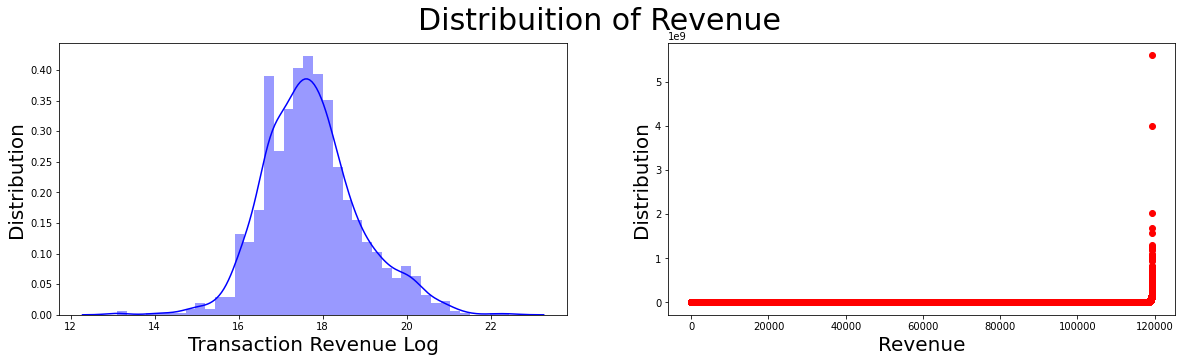

In [27]:
fig = plt.figure(figsize=(20,5))
plt.suptitle('Distribuition of Revenue', fontsize=30)

ax1 = fig.add_subplot(121)
_ = sns.distplot(np.log(df_train[df_train['totals.transactionRevenue'] > 0]['totals.transactionRevenue']), 
                 bins=40,color='blue', ax=ax1)
_ = ax1.set_ylabel('Distribution', fontsize=20)
_ = ax1.set_xlabel('Transaction Revenue Log', fontsize=20)


ax2 = fig.add_subplot(122)
_ = plt.scatter(range(df_train.shape[0]), np.sort(df_train['totals.transactionRevenue'].values), color='red')
_ = ax2.set_ylabel('Distribution', fontsize=20)
_ = ax2.set_xlabel('Revenue', fontsize=20)

In [163]:
#df_train['totals.transactionRevenue'] = df_train['totals.transactionRevenue'].apply(lambda x: np.log1p(x))

Kurtosis and Skewness of Transaction Revenue

In [65]:
print('Excess kurtosis of normal distribution (should be 0): {}'.format(
    kurtosis(df_train[df_train['totals.transactionRevenue'] > 0]["totals.transactionRevenue"])))
print( 'Skewness of normal distribution (should be 0): {}'.format(
    skew((df_train[df_train['totals.transactionRevenue'] > 0]["totals.transactionRevenue"]))))

Excess kurtosis of normal distribution (should be 0): 0.8737955141572828
Skewness of normal distribution (should be 0): 0.38777951430257795


Calculating Outliers

In [30]:
def calculate_outliers(df_num): 

    # calculating mean and sd of the array
    data_mean, data_sd = np.mean(df_num), np.std(df_num)

    # setting the cut line to both higher and lower values
    cut = data_sd * 3

    #Calculating the higher and lower cut values
    lower, upper = data_mean - cut, data_mean + cut

    # creating an array of lower, higher and total outlier values 
    outliers_lower = [x for x in df_num if x < lower]
    outliers_higher = [x for x in df_num if x > upper]
    outliers_total = [x for x in df_num if x < lower or x > upper]

    # array without outlier values
    outliers_removed = [x for x in df_num if x > lower and x < upper]

    # printing total number of values in lower cut of outliers
    print(f'Lower outliers: {len(outliers_lower)}') 
    # printing total number of values in higher cut of outliers
    print(f'Upper outliers: {len(outliers_higher)}')
    # printing total number of values outliers of both sides 
    print(f'Total outliers: {len(outliers_total)}') 
    # printing total number of non outlier values
    print(f'Non - outliers: {len(outliers_removed)}') 
    # Percentage of outliers in points
    print(f'% of Outliers : {round((len(outliers_total) / len(outliers_removed) )*100, 4)}' ) 

In [31]:
calculate_outliers(df_train['totals.transactionRevenue'])

Lower outliers: 0
Upper outliers: 338
Total outliers: 338
Non - outliers: 119073
% of Outliers : 0.2839


Visitors Exploration

In [90]:
print("There are total "+str(df_train.shape[0])+" visits")
print("Number of unique visitors: "+str(df_train["fullVisitorId"].nunique()))
print("Percentage of visits that bought something: %"+str(df_train.loc[df_train["totals.transactionRevenue"] > 0].shape[0]/df_train.shape[0]*100))

train_first_visit = df_train.loc[df_train["visitNumber"] == 1]
print("Percentage of visits that were for the first time: %"+str(train_first_visit.shape[0]/df_train.shape[0]*100))
print("Presentage of first time visitors that bought something: %"+str(train_first_visit.loc[train_first_visit["totals.transactionRevenue"] > 0].shape[0]/df_train.shape[0]*100))

There are total 119819 visits
Number of unique visitors: 114604
Percentage of visits that bought something: %1.0574282876672314
Percentage of visits that were for the first time: %76.5412831020122
Presentage of first time visitors that bought something: %0.411453943030738


Browsers, Devices and Operating System Exploration

In [156]:
plt.figure(figsize=(20,16))
def create_countplot(column, title, plt_n, df= df_train, mean_ch = False):
    labels = list(df[column].value_counts().index.unique())

    fontdict = {'fontsize': 10, 'fontweight' : 'bold'}
    plt.subplot(plt_n)
    if mean_ch:
        sns.barplot(x = column, y="totals.transactionRevenue", data=df, order = labels[:10])
    else:
        sns.countplot(x = column, data=df, order = labels[:10])
    plt.xticks(np.arange(0, len(labels[:10]), 1), labels, rotation=-80)
    plt.title(title, fontdict=fontdict)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.xlabel('')
    plt.ylabel('')


<Figure size 1440x1152 with 0 Axes>

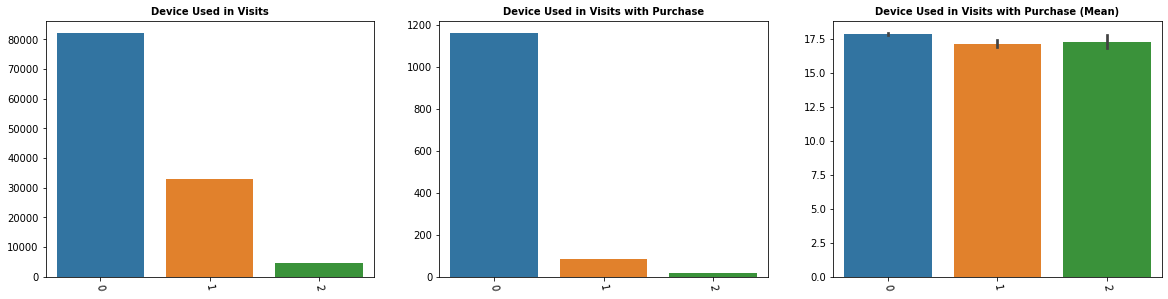

In [159]:
plt.figure(figsize=(20,16))
create_countplot( 'device.deviceCategory', 'Device Used in Visits', 331)
create_countplot( 'device.deviceCategory', 'Device Used in Visits with Purchase', 332, df_train.loc[df_train["totals.transactionRevenue"] > 0])
create_countplot( 'device.deviceCategory', 'Device Used in Visits with Purchase (Mean)', 333, df_train.loc[df_train["totals.transactionRevenue"] > 0], True)

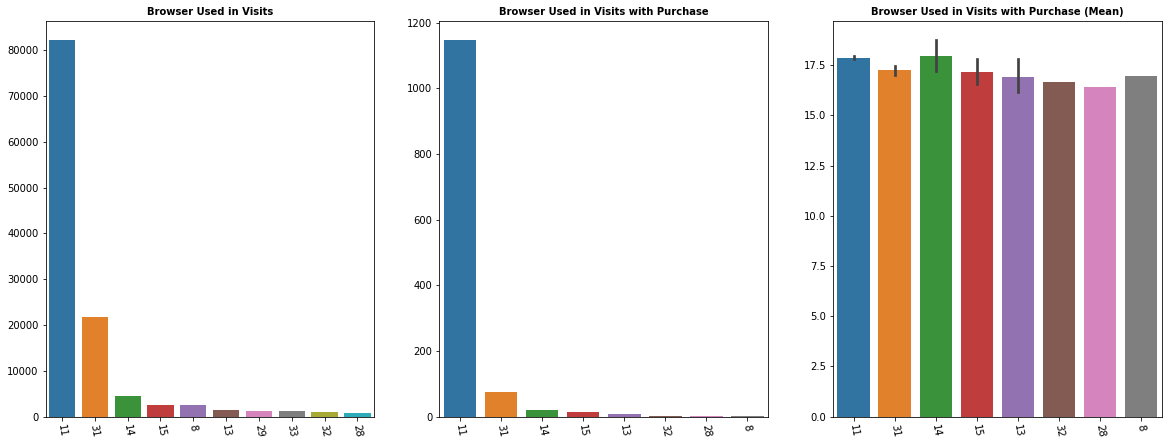

In [161]:
plt.figure(figsize=[20,16])

create_countplot( 'device.browser', 'Browser Used in Visits', 231)
create_countplot( 'device.browser', 'Browser Used in Visits with Purchase', 232, df_train.loc[df_train["totals.transactionRevenue"] > 0])
create_countplot( 'device.browser', 'Browser Used in Visits with Purchase (Mean)', 233, df_train.loc[df_train["totals.transactionRevenue"] > 0], True)

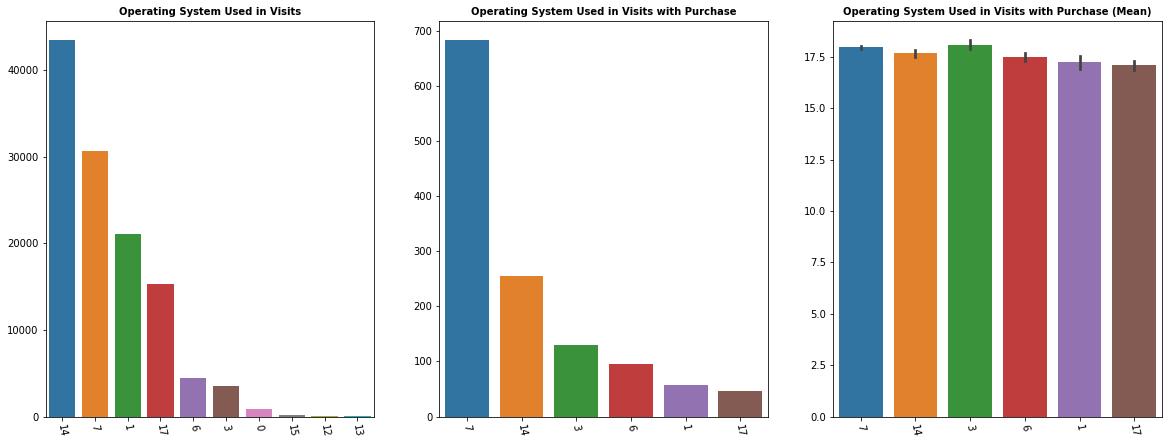

In [162]:
plt.figure(figsize=[20,16])

create_countplot( 'device.operatingSystem', 'Operating System Used in Visits', 231)
create_countplot( 'device.operatingSystem', 'Operating System Used in Visits with Purchase', 232, df_train.loc[df_train["totals.transactionRevenue"] > 0])
create_countplot( 'device.operatingSystem', 'Operating System Used in Visits with Purchase (Mean)', 233, df_train.loc[df_train["totals.transactionRevenue"] > 0], True)

Page Views and Hits Exploration

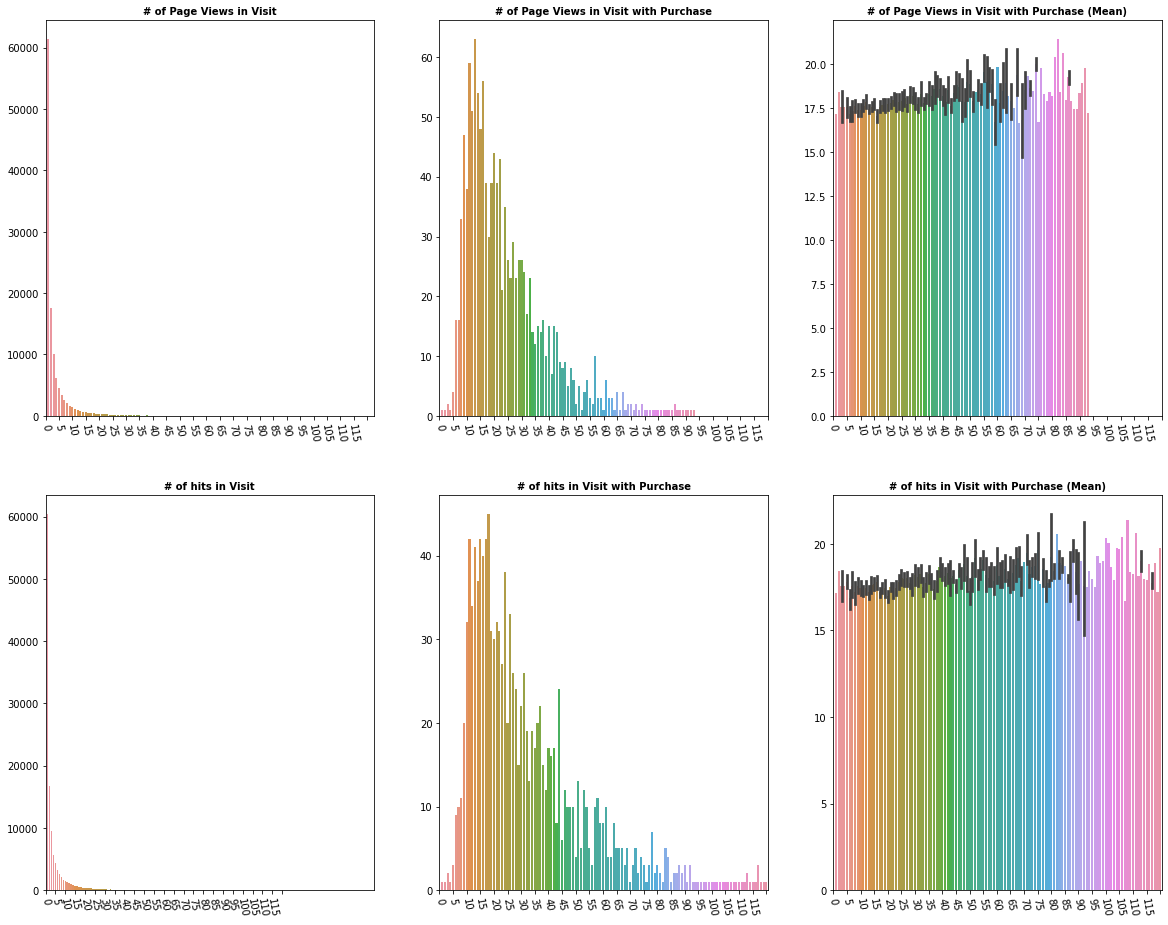

In [172]:

plt.figure(figsize=[20,16])
def create_viewplot(column, title, plt_n, df=df_train, mean_ch = False):
    df = df.loc[df[column] <= 120].sort_values(column) 
    labels = np.arange(0, 120, step=5)
    fontdict = {'fontsize': 10, 'fontweight' : 'bold'}
    plt.subplot(plt_n)
    if mean_ch:
        sns.barplot(x = column, y="totals.transactionRevenue", data=df)
    else:
        sns.countplot(x = column, data=df)
    plt.xticks(np.arange(-1, 120, step=5),labels, rotation=-80)
    plt.title(title, fontdict=fontdict)
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.xlabel('')
    plt.ylabel('')

create_viewplot( 'totals.pageviews', '# of Page Views in Visit', 231)
create_viewplot( 'totals.pageviews', '# of Page Views in Visit with Purchase', 232, df_train.loc[df_train["totals.transactionRevenue"] > 0])
create_viewplot( 'totals.pageviews', '# of Page Views in Visit with Purchase (Mean)', 233, df_train.loc[df_train["totals.transactionRevenue"] > 0], True)

create_viewplot( 'totals.hits', '# of hits in Visit', 234)
create_viewplot( 'totals.hits', '# of hits in Visit with Purchase', 235, df_train.loc[df_train["totals.transactionRevenue"] > 0])
create_viewplot( 'totals.hits', '# of hits in Visit with Purchase (Mean)', 236, df_train.loc[df_train["totals.transactionRevenue"] > 0], True)

plt.show()

Continent and Country Exploration

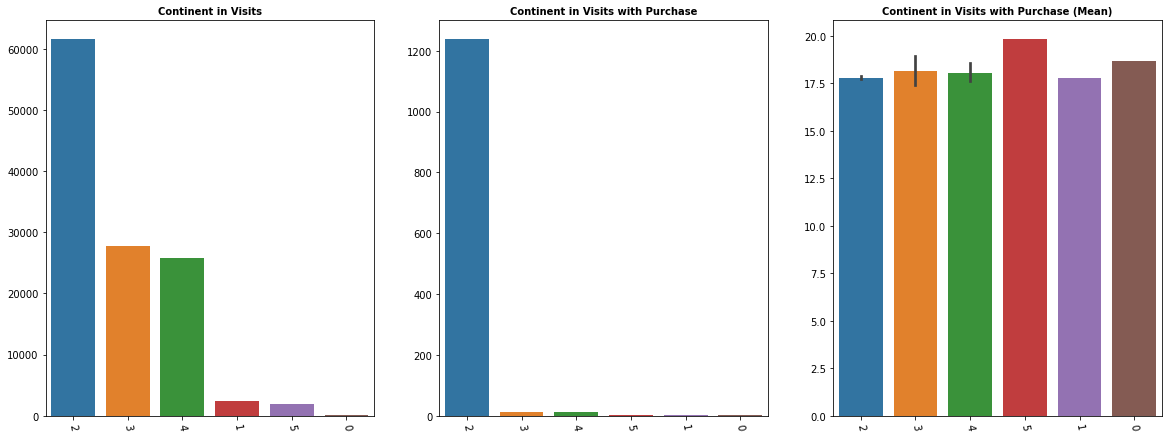

In [163]:
plt.figure(figsize=[20,16])

create_countplot( 'geoNetwork.continent', 'Continent in Visits', 231)
create_countplot( 'geoNetwork.continent', 'Continent in Visits with Purchase', 232, df_train.loc[df_train["totals.transactionRevenue"] > 0])
create_countplot( 'geoNetwork.continent', 'Continent in Visits with Purchase (Mean)', 233, df_train.loc[df_train["totals.transactionRevenue"] > 0], True)

In [169]:
countMaps = pd.DataFrame(df_train['geoNetwork.country'].value_counts()).reset_index()
countMaps.columns=['country', 'counts'] #renaming columns
countMaps = countMaps.reset_index().drop('index', axis=1) #reseting index and droping the column

data = [ dict(
        type = 'choropleth',
        locations = countMaps['country'],
        locationmode = 'country names',
        z = countMaps['counts'],
        text = countMaps['country'],
        colorscale = 'YlGnBu',
        autocolorscale = False,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '',
            title = 'Number of Visits'),
      ) ]

layout = dict(
    title = 'Counting Visits Per Country',
    geo = dict(
        showframe = False,
        showcoastlines = True,
        projection = dict(
            type = 'natural earth'
        )
    )
)

figure = dict( data=data, layout=layout )
iplot(figure, validate=False, filename='map-countrys-count')

 Traffic Source and Channel Grouping 
Exploration

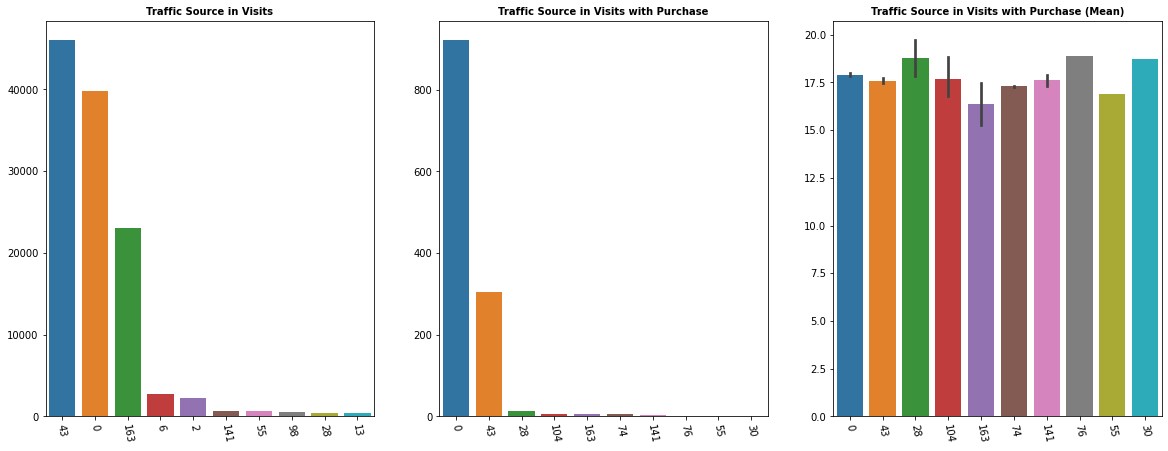

In [167]:
plt.figure(figsize=[20,16])
create_countplot( 'trafficSource.source', 'Traffic Source in Visits', 231)
create_countplot( 'trafficSource.source', 'Traffic Source in Visits with Purchase', 232, df_train.loc[df_train["totals.transactionRevenue"] > 0])
create_countplot( 'trafficSource.source', 'Traffic Source in Visits with Purchase (Mean)', 233, df_train.loc[df_train["totals.transactionRevenue"] > 0], True)

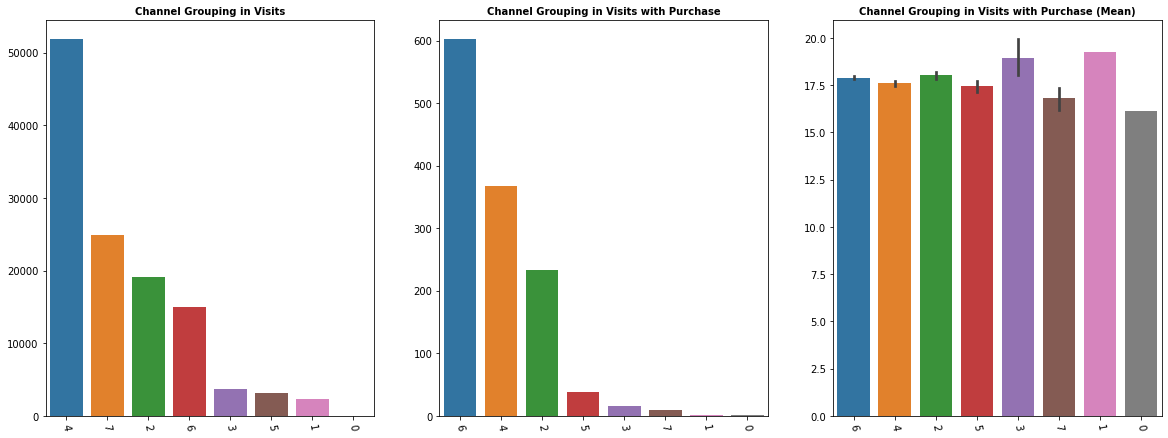

In [168]:
plt.figure(figsize=[20,16])

create_countplot( 'channelGrouping', 'Channel Grouping in Visits', 231)
create_countplot( 'channelGrouping', 'Channel Grouping in Visits with Purchase', 232, df_train.loc[df_train["totals.transactionRevenue"] > 0])
create_countplot( 'channelGrouping', 'Channel Grouping in Visits with Purchase (Mean)', 233, df_train.loc[df_train["totals.transactionRevenue"] > 0], True)

Visits, Revenue and Transactions by Time

In [61]:
# Visits by time

# couting all entries by date to get number of visits by each date
dates_visits = df_train['date'].value_counts().reset_index().sort_values('index') 
# renaming the columns to apropriate names
dates_visits.columns = ['date','visits'] 

# creating the first trace with the necessary parameters
trace1 = go.Scatter(x=dates_visits.date.astype(str), y=dates_visits.visits,
                    opacity = 0.8, line = dict(color = 'darkgreen'), name= 'Visits by day')

# Below we will get the total values by Transaction Revenue Log by date
dates_revenue = df_train.groupby('date')['totals.transactionRevenue'].sum().reset_index()

# using the dates_revenue we will create the second trace
trace2 = go.Scatter(x=dates_revenue.date.astype(str), 
                    y=dates_revenue['totals.transactionRevenue'],
                    opacity = 0.8,line = dict(color = 'Red'), name= "Revenue Log by day")

# Getting the total values by Transactions by each date
dates_transactions = df_train[df_train['totals.transactionRevenue'] > 0].groupby('date')['totals.transactionRevenue'].count().reset_index()

# using the dates_transactions we will create the third trace
trace3 = go.Scatter(x=dates_transactions.date.astype(str), 
                    y=dates_transactions['totals.transactionRevenue'],
                     opacity = 0.8,line = dict(color = 'cyan'), name="Sellings by day")

#creating the layout that will give us some interesting options to handle with the outputs of graphs
layout = dict(
    title= "Information by Date",
    paper_bgcolor='#ffffff',
    template='plotly_white',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label='1m', step='month', stepmode='backward'),
                dict(count=3, label='3m', step='month', stepmode='backward'),
                dict(count=6, label='6m', step='month', stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(visible = True),
        type='date'
    )
)

# creating figure with the both traces and layout
fig = dict(data= [trace1, trace2, trace3], layout=layout)

#rendering the graphs
iplot(fig) #it's an equivalent to plt.show()

Hour of the day when the Revenue is High

In [62]:
pd.crosstab(df_train['visitHour'],
            df_train['weekday'], 
            values=df_train['totals.transactionRevenue'], 
            aggfunc='sum').style.background_gradient(cmap='viridis')

weekday,0,1,2,3,4,5,6
visitHour,,,,,,,
0,188.573630,202.963915,107.355173,107.974340,86.161496,104.362512,124.124314
1,184.206959,91.848895,157.519685,172.308231,53.957042,88.139078,86.871712
2,194.500565,173.514965,142.013268,142.003289,107.765952,134.726833,34.864267
3,191.550778,179.086582,233.061133,34.921939,86.953329,89.450180,83.365585
4,68.887787,306.351018,52.876052,105.554687,123.105657,108.155082,122.139548
5,121.391744,88.005811,67.419260,106.942165,35.209969,120.046912,14.966083
6,120.616564,52.609403,0.000000,87.852017,0.000000,54.926885,19.187311
7,53.711523,38.161857,35.508934,16.835448,0.000000,32.951408,53.233730
8,16.856694,0.000000,55.133641,18.320308,0.000000,0.000000,55.964710


# Modelling

Test Data Reading and Processing

In [64]:
%%time 
# %%time is used to calculate the timing of code chunk execution #

df_test = json_read("test_v2.csv")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead



Loaded test_v2.csv. Shape: (28031, 59)
CPU times: user 46.1 s, sys: 725 ms, total: 46.8 s
Wall time: 47.3 s


In [65]:
non_relevant = ["visitNumber", "date", "fullVisitorId", "sessionId", "visitId", "visitStartTime"]
df_test = fill_na(df_test)
df_test = date_process(df_test)
df_test.drop(constant_columns, axis=1, inplace=True)
Null_Count(df_test)
df_test.drop(list(Null_Count(df_test)['Column']), axis=1,inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [160]:
#df_pca= df_train.drop(['customDimensions','date','fullVisitorId','hits','visitId','visitStartTime','trafficSource.campaign','weekday','day','month','year','visitHour'],axis=1)
X_train = df_train[['totals.hits','totals.pageviews','totals.newVisits','totals.bounces']] 
Y_train = df_train['totals.transactionRevenue']
X_test = df_test[['totals.hits','totals.pageviews','totals.newVisits','totals.bounces']] 
Y_test = df_test['totals.transactionRevenue']

In [161]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

PCA

In [162]:
pca = PCA()
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.39435306, 0.26637956, 0.23360519, 0.10566219])

In [163]:
pca = PCA(n_components=3)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

LDA

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA()
X_train = lda.fit_transform(X_train, Y_train)
X_test = lda.transform(X_test)
explained_variance = lda.explained_variance_ratio_
explained_variance

In [ ]:
lda = LDA(n_components=3)
X_train = lda.fit_transform(X_train, Y_train)
X_test = lda.transform(X_test)

Encoding Categorical Columns

In [66]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

cat_columns = [c for c in df_train.columns if not c.startswith('total')]
cat_columns = [c for c in cat_columns if c not in non_relevant]
for c in cat_columns:

    df_train[c] = le.fit_transform(df_train[c])
    df_test[c] = le.fit_transform(df_test[c])
    

Normalizing Numerical Columns

In [43]:
def normalize(df,feature_name):
  #result = df.copy()
  df[feature_name] = df[feature_name].astype(int)
  max_value = df[feature_name].max()
  min_value = df[feature_name].min()
  df[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)

In [67]:
num_columns = ['totals.hits', 'totals.pageviews', 'totals.bounces',  'totals.newVisits'] 

for col in num_columns:
  normalize(df_train,col) 
  normalize(df_test,col) 

Dividing the data into train and test

In [68]:
from sklearn.model_selection import train_test_split
features = [c for c in df_train.columns if c not in non_relevant]
features.remove("totals.transactionRevenue")
df_train["totals.transactionRevenue"] = np.log1p(df_train["totals.transactionRevenue"].astype(float))
train_x, val_x, train_y, val_y = train_test_split(df_train[features], df_train["totals.transactionRevenue"], test_size=0.3, random_state=20)

Light GBM

In [69]:
import lightgbm as lgb 

lgb_params = {"objective" : "regression", 
              "metric" : "rmse",
              "num_leaves" : 36,
              "learning_rate" : 0.05, 
              "bagging_fraction" : 0.75, 
              "feature_fraction" : 0.6, 
              "bagging_frequency" : 7}
    
lgb_train = lgb.Dataset(train_x, label=train_y)
lgb_val = lgb.Dataset(val_x, label=val_y)
model = lgb.train(lgb_params, lgb_train, 300, valid_sets=[lgb_val], early_stopping_rounds=50, verbose_eval=100)

Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.56328
Early stopping, best iteration is:
[104]	valid_0's rmse: 1.56297


In [70]:
#saving model to pkl file
import joblib
joblib.dump(model,'lgbm_model.pkl')

['lgbm_model.pkl']

In [71]:
#loading model from pkl file
load_lgbm_pkl = joblib.load('lgbm_model.pkl')

In [72]:
#predicting revenue from loaded model
pred = load_lgbm_pkl.predict(df_test[features], num_iteration=load_lgbm_pkl.best_iteration) 

df_test["PredictedRevenue"] = pred
sub_df = df_test.groupby(["channelGrouping","device.browser","device.operatingSystem","device.deviceCategory","geoNetwork.continent","geoNetwork.country","trafficSource.source","trafficSource.medium","weekday","visitHour"]).agg({"PredictedRevenue" : "sum"}).reset_index()
sub_df["PredictedRevenue"] = sub_df["PredictedRevenue"]
sub_df["PredictedRevenue"] =  sub_df["PredictedRevenue"].apply(lambda x : 0.0 if x < 0 else x)
#sub_df.to_csv("baseline.csv", index=False)
sub_df.head()

,channelGrouping,device.browser,device.operatingSystem,device.deviceCategory,geoNetwork.continent,geoNetwork.country,trafficSource.source,trafficSource.medium,weekday,visitHour,PredictedRevenue
0,0,3,1,1,4,54,1,1,6,11,0.0
1,0,4,1,1,1,3,1,1,2,1,0.0
2,0,4,1,1,1,46,1,1,0,6,0.0
3,0,4,1,1,1,108,1,1,0,15,0.0
4,0,4,1,1,2,115,1,1,0,14,0.0
